# Greedy MSU selection

Choose MSU locations based on which improves overall utility most.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from classes.geography_processing import Geoprocessing
from classes.model import Model
from classes.scenario import Scenario

# Turn off all warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Proportion of treated patients that are LVO
prop_lvo = 0.30

# Maximum number of hospitals to select
max_hospitals = 100

## Base case

MSU provided from comprehensive stroke centres (thrombectomy centres)

In [3]:
# Set up scenario
scenario = Scenario({
    'name': 1,
    'limit_to_england' : True
})

# Process and save geographic data (only needed when hospital data changes)
geo = Geoprocessing(limit_to_england=True); geo.run()

# Set up model
model = Model(
    scenario=scenario,
    geodata=pd.read_csv('processed_data/processed_data.csv'))

# Run model
model.run()

# Get utilities
lsoa_drip_ship_utility = (
    (model.full_results['lvo_drip_ship_ivt_mt_utility'] * prop_lvo) + 
    (model.full_results['nlvo_drip_ship_ivt_utility'] * (1 - prop_lvo)))

# Get the weighted average of lsoa_drip_ship_utility 
average_utility_drip_ship = np.sum(
    model.full_results['Admissions'] * lsoa_drip_ship_utility) / np.sum(model.full_results['Admissions'])

lsoa_drip_ship_utility_shift = (
    (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
    (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

lsoa_msu_utility_shift = (
    (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
    (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

# Get the maximum of MSU and drip and ship
best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

# Get the weighted average of lsoa_drip_ship_utility shift 
average_utility_drip_ship_shift = np.sum(
    model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

# Get the average utility weighted by model.full_results['Admissions']
average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

# Get the advantage of MSU over drip and ship
advantage = average_utility_shift - average_utility_drip_ship_shift

In [4]:
untreated_utility = (average_utility_drip_ship - average_utility_drip_ship_shift)
print(f'Average untreated utility: {untreated_utility:0.3f}')
print(f'Average utility improvement for drip and ship: {average_utility_drip_ship_shift:0.3f}')
print(f'Average utility advantage for MSU over drip and ship: {advantage:0.3f}')


Average untreated utility: 0.520
Average utility improvement for drip and ship: 0.086
Average utility advantage for MSU over drip and ship: 0.022


In [5]:
# Set up scenario
scenario = Scenario({
    'name': 1,
})

# Set up geoprocessing module and load initial data (and  set Use_MSU column to zero
geo = Geoprocessing(limit_to_england = True)
geo.load_data()
geo.hospitals['Use_MSU'] = 0

# Travel processing for constant locations
geo.find_nearest_ivt_unit()
geo.find_nearest_mt_unit()
geo.find_nearest_transfer_mt_unit()

# Set up list of selected and unselected MSUs
selected_MSUs = []
used_hospitals_mask = geo.hospitals['Use_IVT'] == 1
unelected_MSUs = list(geo.hospitals[used_hospitals_mask].index)

## Benefit from each hospital as a MSU base


In [6]:
geo.hospitals['Use_MSU'] = 0
hospitals = geo.hospitals.copy(deep=True)
                                   
# Loop through all MSUs
possible_msu_locations = list(geo.hospitals[used_hospitals_mask].index)
advantages = []

for msu in possible_msu_locations:
    data_copy = hospitals.copy(deep=True)
    data_copy.loc[msu, 'Use_MSU'] = 1
    geo.hospitals = data_copy.copy()
    geo.find_nearest_msu_unit()
    geo.collate_data()
    geo.save_processed_data()

    model = Model(
        scenario=scenario,
        geodata=pd.read_csv('processed_data/processed_data.csv')
    )

    model.run()

    # Get utilitites
    lsoa_msu_utility_shift = (
        (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
        (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

    lsoa_drip_ship_utility_shift = (
        (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
        (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

    # Get the maximum of MSU and drip and ship
    best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

    # Get the weighted average of lsoa_drip_ship_utility
    average_utility_drip_ship_shift = np.sum(
        model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

    # Get the average utility weighted by model.full_results['Admissions']
    average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

    # Get the advantage of MSU over drip and ship
    advantage = average_utility_shift - average_utility_drip_ship_shift

    advantages.append(advantage)


results = geo.hospitals.copy(deep=True)
results = results[used_hospitals_mask]
results['MSU advantage'] = advantages

results.to_csv('output/msu_advantages_individual.csv')

## Greedy selection of MSUs

In [7]:
hospitals = geo.hospitals.copy(deep=True)
best_advantage = 0
advantages = []

# Loop through greedy selection process
while (len(unelected_MSUs) > 0) & (len(selected_MSUs) < max_hospitals):

    # Loop through all MSUs
    for msu in unelected_MSUs:
        data_copy = hospitals.copy(deep=True)
        data_copy.loc[msu, 'Use_MSU'] = 1
        geo.hospitals = data_copy.copy()
        geo.find_nearest_msu_unit()
        geo.collate_data()
        geo.save_processed_data()

        model = Model(
            scenario=scenario,
            geodata=pd.read_csv('processed_data/processed_data.csv')
        )

        model.run()
        
            # Get utilitites
        lsoa_msu_utility_shift = (
            (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
            (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

        lsoa_drip_ship_utility_shift = (
            (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
            (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

        # Get the maximum of MSU and drip and ship
        best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

        # Get the weighted average of lsoa_drip_ship_utility
        average_utility_drip_ship_shift = np.sum(
            model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

        # Get the average utility weighted by model.full_results['Admissions']
        average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

        # Get the advantage of MSU over drip and ship
        advantage = average_utility_shift - average_utility_drip_ship_shift
        
        if advantage > best_advantage:
            best_advantage = advantage
            best_MSU = msu

    # Add the best MSU to the selected list
    selected_MSUs.append(best_MSU)
    unelected_MSUs.remove(best_MSU)
    hospitals.loc[best_MSU, 'Use_MSU'] = 1
    advantages.append(best_advantage)

    # print the best MSU and utility
    print(f'{best_MSU}, {best_advantage:0.3f}')

E11BB, 0.006
M68HD, 0.010
B714HJ, 0.012
DN25LT, 0.014
DH15TW, 0.015
KT160PZ, 0.016
BS105NB, 0.017
PE39GZ, 0.018
EX25DW, 0.018
NR47UY, 0.019
DA28DA, 0.020
NG72UH, 0.020
LS13EX, 0.021
LU40DZ, 0.021
BN112DH, 0.022
CO45JL, 0.022
L97AL, 0.022
PR29HT, 0.022
TR13LQ, 0.023
HU32JZ, 0.023
ST46QG, 0.023
CV22DX, 0.023
BH77DW, 0.024
GL13NN, 0.024
CA27HY, 0.024
CT13NG, 0.024
NE14LP, 0.024
TS43BW, 0.025
HA13UJ, 0.025
PL68DH, 0.025
BA214AT, 0.025
OX39DU, 0.025
S102JF, 0.025
BN212UD, 0.025
CB20QQ, 0.026
SS165NL, 0.026
TF16TF, 0.026
LN25QY, 0.026
PO63LY, 0.026
NN15BD, 0.026
SW170QT, 0.026
EX314JB, 0.026
RG15AN, 0.026
LE15WW, 0.027
YO318HE, 0.027
PO305TG, 0.027
SN36BB, 0.027
SK27JE, 0.027
HR12ER, 0.027
CH495PE, 0.027
DE223NE, 0.027
LA144LF, 0.027
BD96RJ, 0.027
PE304ET, 0.027
BS234TQ, 0.027
NG174JL, 0.028
RM70AG, 0.028
NR316LA, 0.028
TQ27AA, 0.028
SG14AB, 0.028
WR51DD, 0.028
BL97TD, 0.028
BA13NG, 0.028
ME169QQ, 0.028
IP45PD, 0.028
RH15RH, 0.028
GU167UJ, 0.028
NW12BU, 0.028
TA15DA, 0.028
HP112TT, 0.028
BB2

In [8]:
greedy_results = geo.hospitals.loc[selected_MSUs]
greedy_results['MSU advantage'] = advantages
greedy_results.to_csv('output/msu_advantages_greedy.csv', index=False)
greedy_results

,Hospital_name,Use_IVT,Use_MT,Use_MSU,Country,Strategic Clinical Network,Health Board / Trust,Stroke Team,SSNAP name,Admissions 21/22,...,ivt_rate,Easting,Northing,long,lat,Neuroscience,30 England Thrombectomy Example,hospital_city,Notes,MSU advantage
Postcode,,,,,,,,,,,,,,,,,,,,,
E11BB,E11BB,1,1,1,England,London SCN,Barts Health NHS Trust,The Royal London Hospital,Royal London Hospital HASU,861,...,13.4,534829,181798,-0.058133,51.519018,1,1,Royal London,NaN,0.005759
M68HD,M68HD,1,1,1,England,Manchester,Lancashire & S.Cumbria SCN,Salford Royal NHS Foundation Trust,Salford Royal Hospital,1848,...,6.5,378637,399030,-2.323424,53.487545,1,1,Salford,NaN,0.009504
B714HJ,B714HJ,1,0,1,England,West Midlands SCN,Sandwell and West Birmingham Hospitals NHS Trust,"Sandwell District Hospital, West Bromwich",Sandwell District Hospital,741,...,6.7,400919,292165,-1.987884,52.527357,0,0,West Bromwich,NaN,0.012298
DN25LT,DN25LT,1,0,1,England,Yorkshire and The Humber SCN,Doncaster and Bassetlaw Hospitals NHS Foundati...,Doncaster Royal Infirmary,Doncaster Royal Infirmary,694,...,9.5,459143,404157,-1.109226,53.530751,0,0,Doncaster,NaN,0.013991
DH15TW,DH15TW,1,0,1,England,North of England SCN,County Durham and Darlington NHS Foundation Trust,University Hospital of North Durham,University Hospital of North Durham,961,...,9.8,426217,543809,-1.593834,54.788497,0,0,North Durham,NaN,0.015386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WD180HB,WD180HB,1,0,1,England,East of England SCN,West Hertfordshire Hospitals NHS Trust,Watford General Hospital,Watford General Hospital,607,...,13.5,510505,195664,-0.404187,51.648921,0,0,Watford,NaN,0.029069
TS198PE,TS198PE,1,0,1,England,North of England SCN,North Tees and Hartlepool NHS Foundation Trust,University Hospitals of North Tees and Hartlepool,University Hospitals of North Tees and Hartlepool,632,...,19.0,442265,521046,-1.347581,54.582857,0,0,Stockton-on-Tees,NaN,0.029091
SW66SX,SW66SX,1,1,1,England,London SCN,Imperial College Healthcare NHS Trust,"Charing Cross Hospital, London",Charing Cross Hospital HASU,1147,...,9.9,524226,176487,-0.212736,51.473717,1,1,Charing Cross,NaN,0.029113


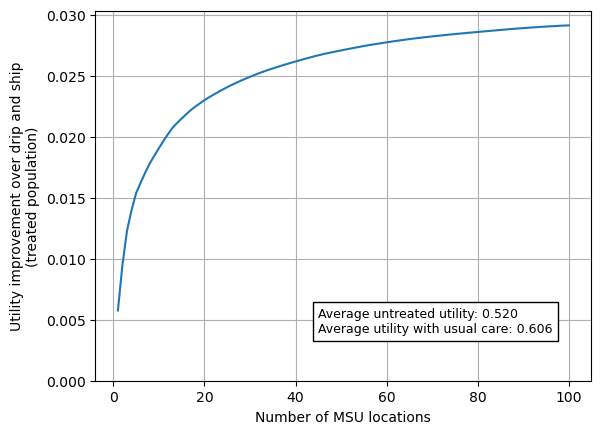

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(len(greedy_results)) + 1
y = greedy_results['MSU advantage']
ax.plot(x, y, '-')
ax.set_xlabel('Number of MSU locations')
ax.set_ylabel('Utility improvement over drip and ship\n(treated population)')
ax.set_ylim(0)
ax.grid()

txt = f'Average untreated utility: {untreated_utility:0.3f}' + '\n' + \
    f'Average utility with usual care: {average_utility_drip_ship:0.3f}'

plt.text(45, 0.006, txt, fontsize=9, color='black', ha='left', va='top', wrap=True, 
         bbox=dict(facecolor='white', edgecolor='black', alpha=1.0))
plt.savefig('output/msu_advantages_greedy.png', dpi=300)

plt.show()
